In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# nifty 50 around 2016-17 and 2 expiry periods, 1month, 3 months, call/put options

# 1 month Expiry Period

In [3]:
options_data = pd.read_csv('datasets/nifty50_options_data.csv')
historical_data = pd.read_csv('datasets/nifty50_historical.csv')
options_data.columns = [column.strip() for column in options_data.columns]
historical_data.columns = [column.strip() for column in historical_data.columns]
historical_data = pd.DataFrame(historical_data)
historical_data = historical_data.dropna()

# Select relevant columns from options data and drop rows with values=nan(missing values)
options_data = pd.DataFrame(options_data[['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close']])
options_data_put = pd.read_csv('datasets/nifty50_options_data_put.csv')
options_data_put.columns = [column.strip() for column in options_data_put.columns]
options_data = options_data.dropna()

options_data["Expiry"] = pd.to_datetime(options_data['Expiry'], format='%d%b%Y')
options_data["Date"] = pd.to_datetime(options_data['Date'], format='%d%b%Y')

options_data_put = pd.DataFrame(options_data_put[['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close']])
options_data_put = options_data_put.dropna()
options_data_put["Expiry"] = pd.to_datetime(options_data_put['Expiry'], format='%d%b%Y')
options_data_put["Date"] = pd.to_datetime(options_data_put['Date'], format='%d%b%Y')

print(options_data_put.columns)
print(options_data.columns)

# Concatenate(Merge) options data and put options data
options_data = pd.concat([options_data, options_data_put])
# print(options_data)

options_data = options_data.sort_values(by='Date').reset_index(drop=True)
print(options_data)

Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close'], dtype='object')
Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close'], dtype='object')
     Symbol       Date     Expiry Option type  Strike Price    Close
0     NIFTY 2016-12-01 2017-01-25          CE       10000.0     1.50
1     NIFTY 2016-12-01 2017-01-25          PE        7250.0     0.70
2     NIFTY 2016-12-01 2017-01-25          PE        7300.0    19.30
3     NIFTY 2016-12-01 2017-01-25          PE        7350.0     1.30
4     NIFTY 2016-12-01 2017-01-25          PE        7400.0    24.80
...     ...        ...        ...         ...           ...      ...
3303  NIFTY 2016-12-30 2017-01-25          CE        8800.0     2.35
3304  NIFTY 2016-12-30 2017-01-25          CE        8850.0     1.95
3305  NIFTY 2016-12-30 2017-01-25          CE        8900.0     1.40
3306  NIFTY 2016-12-30 2017-01-25          CE        8550.0    10.95
3307  NIFTY 2016-12-30 2017-01-25          PE        9950

# 3 months expiry period

In [3]:
options_data = pd.read_csv('datasets/high_expiry_nifty50_options_data.csv')
historical_data = pd.read_csv('datasets/nifty50_historical.csv')
options_data.columns = [column.strip() for column in options_data.columns]
historical_data.columns = [column.strip() for column in historical_data.columns]
historical_data = pd.DataFrame(historical_data)
historical_data = historical_data.dropna()

options_data = pd.DataFrame(options_data[['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close']])
options_data_put = pd.read_csv('datasets/high_expiry_options_data_put.csv')
options_data_put.columns = [column.strip() for column in options_data_put.columns]
options_data = options_data.dropna()

options_data["Expiry"] = pd.to_datetime(options_data['Expiry'], format='%d%b%Y')
options_data["Date"] = pd.to_datetime(options_data['Date'], format='%d%b%Y')

options_data_put = pd.DataFrame(options_data_put[['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close']])
options_data_put = options_data_put.dropna()
options_data_put["Expiry"] = pd.to_datetime(options_data_put['Expiry'], format='%d%b%Y')
options_data_put["Date"] = pd.to_datetime(options_data_put['Date'], format='%d%b%Y')

print(options_data_put.columns)
print(options_data.columns)

options_data = pd.concat([options_data, options_data_put])

options_data = options_data.sort_values(by='Date').reset_index(drop=True)
print(options_data)

Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close'], dtype='object')
Index(['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close'], dtype='object')
     Symbol       Date     Expiry Option type  Strike Price    Close
0     NIFTY 2016-12-01 2017-03-30          CE       10000.0     7.50
1     NIFTY 2016-12-01 2017-03-30          PE        6500.0    82.05
2     NIFTY 2016-12-01 2017-03-30          PE        6400.0    70.00
3     NIFTY 2016-12-01 2017-03-30          PE        6300.0    59.35
4     NIFTY 2016-12-01 2017-03-30          PE        6200.0    50.00
...     ...        ...        ...         ...           ...      ...
2871  NIFTY 2016-12-30 2017-03-30          CE        8350.0   216.75
2872  NIFTY 2016-12-30 2017-03-30          CE        8400.0   152.70
2873  NIFTY 2016-12-30 2017-03-30          CE        8450.0   178.45
2874  NIFTY 2016-12-30 2017-03-30          CE        8000.0   383.20
2875  NIFTY 2016-12-30 2017-03-30          PE        9900

In [4]:
log_returns = np.log(historical_data["Close"] / historical_data["Close"].shift(1))
annual_volatility = log_returns.std() * np.sqrt(252)

In [19]:
def black_scholes(S, K, T, r, sigma, option_type='CE'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'CE':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

def binomial_model(S, K, T, r, sigma, steps=10, option_type='CE'):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount_factor = np.exp(-r * dt)
    
    # Initialize asset prices at maturity
    prices = np.zeros(steps + 1)
    for i in range(steps + 1):
        prices[i] = S * (u ** (steps - i)) * (d ** i)
    
    # Initialize option values at maturity
    if option_type == 'CE':
        option_values = np.maximum(prices - K, 0)
    else:
        option_values = np.maximum(K - prices, 0)
    
    # Backward induction for option price
    for i in range(steps - 1, -1, -1):
        option_values = discount_factor * (p * option_values[:-1] + (1 - p) * option_values[1:])
        
    return option_values[0]

In [20]:
# r = 0.0676 # Risk-free rate(saw from government bonds data from internet around the 1 month period we are taking into account)
r = 0.069 # for 3 months period
current_index_price = historical_data["Close"].iloc[-1]  # Most recent index price

# Comparing model prices to market prices
results=[]

for index, row in options_data.iterrows():
    S = current_index_price
    K = row['Strike Price']
    T = (row['Expiry'] - row['Date']).days / 365.0
    if T == 0:
        print(row['Date'])
    market_price = row['Close']
    option_type = row['Option type']

    bs_price = black_scholes(S, K, T, r, annual_volatility, option_type)
    bin_price = binomial_model(S, K, T, r, annual_volatility, option_type=option_type)
    results.append({
        'Type': option_type,
        'Strike': K,
        'Expiry': row['Expiry'],
        'Market Price': market_price,
        'BS Price': bs_price,
        'Binomial Price': bin_price,
        'BS Error': abs(bs_price - market_price),
        'Binomial Error': abs(bin_price - market_price),
        'Date': row['Date'],
        '% Binomial Error': (bin_price-market_price)/market_price,
        '% BS Error': (bs_price-market_price)/market_price
    })

results_df = pd.DataFrame(results)

# print(results_df)

Mean Error Black-Scholes:  0.010658089179877896
Mean Error Binomial:  -0.019952964531327777
Standard Deviation of Error Black-Scholes:  1.0783050643198422
Standard Deviation of Error Binomial:  1.0204906183157973


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

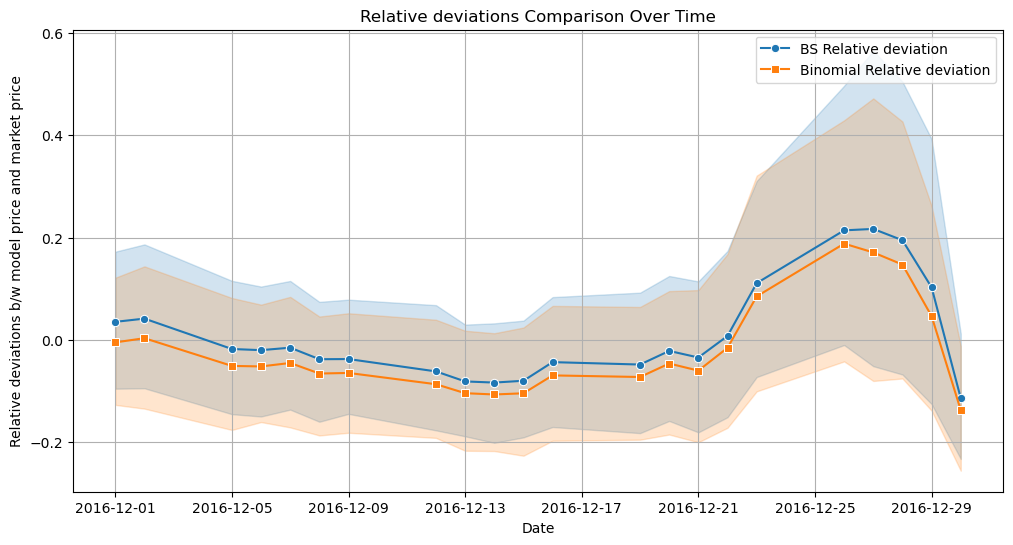

In [21]:
# With step size 2 in Binomial Model

print("Mean Error Black-Scholes: ", results_df['% BS Error'].mean())
print("Mean Error Binomial: ", results_df['% Binomial Error'].mean())
print("Standard Deviation of Error Black-Scholes: ", results_df['% BS Error'].std())
print("Standard Deviation of Error Binomial: ", results_df['% Binomial Error'].std())
# print(results_df.columns)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='% BS Error', data=results_df, label='BS Relative deviation', marker='o')
sns.lineplot(x='Date', y='% Binomial Error', data=results_df, label='Binomial Relative deviation', marker='s')
plt.xlabel('Date')
plt.ylabel('Relative deviations b/w model price and market price')
plt.title('Relative deviations Comparison Over Time')
plt.legend()
plt.grid(True)
# plt.savefig("3month_jan_feb_relative_10steps")
plt.show()

